In [1]:
import pandas as pd
import numpy as np

In [2]:
columns = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
           "wrong_fragment","urgent","hot","num_failed_logins","logged_in",
           "num_compromised","root_shell","su_attempted","num_root","num_file_creations",
           "num_shells","num_access_files","num_outbound_cmds","is_host_login",
           "is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
           "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate",
           "srv_diff_host_rate","dst_host_count","dst_host_srv_count",
           "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
           "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
           "dst_host_rerror_rate","dst_host_srv_rerror_rate","label", "difficulty"]

In [5]:
url = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.txt"

In [6]:
try:
    df = pd.read_csv(url, names=columns)
    print(f"Successfully loaded {len(df)} rows!")
    print(df.head())
except Exception as e:
    print(f"Error loading data: {e}")

Successfully loaded 125973 rows!
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.17   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.10   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    1.00   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.03                         0.17   
1                    0.60              

In [8]:
df['target']=df['label'].apply(lambda x: 0 if x =='normal' else 1)

In [9]:
df.drop(['label','difficulty'], axis=1, inplace=True)

In [10]:
print(f"Dataset loaded: {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset loaded: 125973 rows and 42 columns.


In [11]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


In [12]:
from sklearn.preprocessing import LabelEncoder
cat_cols=['protocol_type','service','flag']
le=LabelEncoder()
for col in cat_cols:
  df[col]=le.fit_transform(df[col])
print("Categorical columns encoded successfully")

Categorical columns encoded successfully


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

normal_data = df[df['target'] == 0]
anomaly_data = df[df['target'] == 1]

train_df, test_normal_df = train_test_split(normal_data, test_size=0.2, random_state=42)
test_df=pd.concat([test_normal_df,anomaly_data])

X_train=train_df.drop('target',axis=1)
X_test=test_df.drop('target',axis=1)
y_test=test_df['target']

scaler=MinMaxScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

print(f"Ready! Training on {X_train_scaled.shape[0]} normal samples.")
print(f"Testing on {X_test_scaled.shape[0]} mixed samples")

Ready! Training on 53874 normal samples.
Testing on 72099 mixed samples


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense

In [16]:
input_dim=X_train_scaled.shape[1]

Initial Model

In [43]:
input_layer_v1=Input(shape=(input_dim,))
x1=Dense(32,activation='relu')(input_layer_v1)
x1=Dense(16,activation='relu')(x1)
bottleneck_v1=Dense(8,activation='relu')(x1)

In [45]:
x1=Dense(16,activation='relu')(bottleneck_v1)
x1=Dense(32,activation='relu')(x1)
decoder=Dense(64,activation='relu')(decoder)
output_layer_v1=Dense(input_dim,activation='sigmoid')(x1)

In [46]:
autoencoder_v1=Model(inputs=input_layer_v1,outputs=output_layer_v1)
autoencoder_v1.compile(optimizer='adam',loss='mse')

In [47]:
print("Training Baseline Model...")
autoencoder_v1.fit(X_train_scaled, X_train_scaled, epochs=25, batch_size=64, validation_split=0.1, verbose=0)

Training Baseline Model...


In [48]:
train_mse_v1 = np.mean(np.power(X_train_scaled - autoencoder_v1.predict(X_train_scaled), 2), axis=1)
threshold_v1 = np.mean(train_mse_v1) + 3 * np.std(train_mse_v1)

1684/1684 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [49]:
mse_v1 = np.mean(np.power(X_test_scaled - autoencoder_v1.predict(X_test_scaled), 2), axis=1)
preds_v1 = (mse_v1 > threshold_v1).astype(int)

2254/2254 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [50]:
print("\n--- BASELINE RESULTS (v1) ---")
print(classification_report(y_test, preds_v1, target_names=['Normal', 'DDoS']))


--- BASELINE RESULTS (v1) ---
              precision    recall  f1-score   support

      Normal       0.60      0.97      0.74     13469
        DDoS       0.99      0.85      0.91     58630

    accuracy                           0.87     72099
   macro avg       0.79      0.91      0.83     72099
weighted avg       0.92      0.87      0.88     72099



Optimized Model

In [51]:
input_layer_v2 = Input(shape=(input_dim,))
x2 = Dense(64, activation='relu')(input_layer_v2)
x2 = Dense(32, activation='relu')(x2)
x2 = Dense(16, activation='relu')(x2)
bottleneck_v2 = Dense(8, activation='relu')(x2)

In [52]:
x2 = Dense(16, activation='relu')(bottleneck_v2)
x2 = Dense(32, activation='relu')(x2)
x2 = Dense(64, activation='relu')(x2)
output_layer_v2 = Dense(input_dim, activation='sigmoid')(x2)

In [53]:
autoencoder_v2 = Model(inputs=input_layer_v2, outputs=output_layer_v2)
autoencoder_v2.compile(optimizer='adam', loss='mse')

In [54]:
print("Training Optimized Model...")
autoencoder_v2.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=64, validation_split=0.1, verbose=0)

Training Optimized Model...


In [55]:
train_mse_v2 = np.mean(np.power(X_train_scaled - autoencoder_v2.predict(X_train_scaled), 2), axis=1)
threshold_v2 = np.mean(train_mse_v2) + 4 * np.std(train_mse_v2)

1684/1684 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [56]:
mse_v2 = np.mean(np.power(X_test_scaled - autoencoder_v2.predict(X_test_scaled), 2), axis=1)
preds_v2 = (mse_v2 > threshold_v2).astype(int)

2254/2254 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [57]:
print("\n--- OPTIMIZED RESULTS (v2) ---")
print(classification_report(y_test, preds_v2, target_names=['Normal', 'DDoS']))


--- OPTIMIZED RESULTS (v2) ---
              precision    recall  f1-score   support

      Normal       0.70      0.99      0.82     13469
        DDoS       1.00      0.90      0.95     58630

    accuracy                           0.92     72099
   macro avg       0.85      0.95      0.88     72099
weighted avg       0.94      0.92      0.92     72099



In [58]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

t-SNE

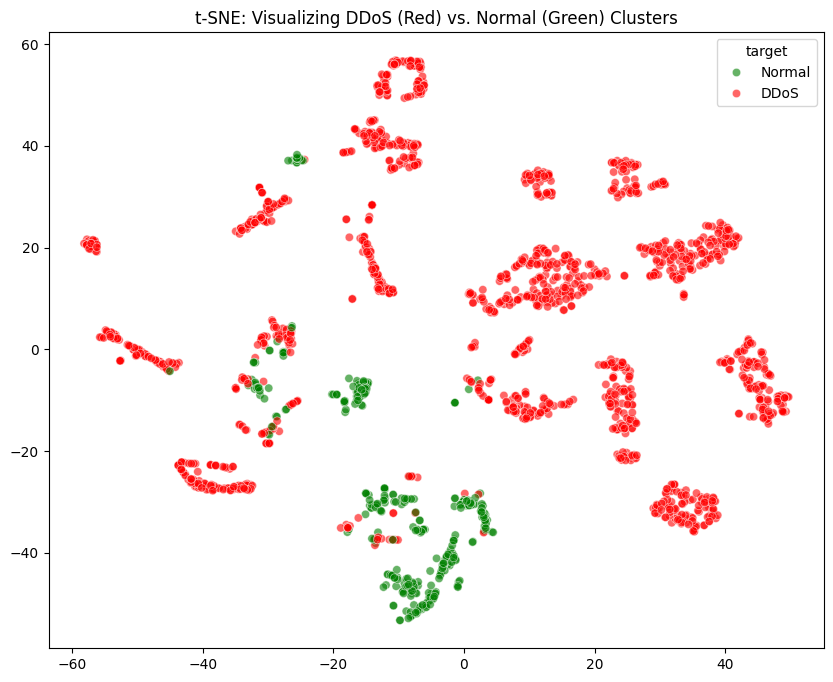

In [60]:
test_df_shuffled = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

X_sample_raw = test_df_shuffled.drop('target', axis=1)[:2000]
y_sample = test_df_shuffled['target'][:2000]

X_sample_scaled = scaler.transform(X_sample_raw)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_sample_scaled)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_tsne[:, 0], y=X_tsne[:, 1],
    hue=y_sample.replace({0: 'Normal', 1: 'DDoS'}),
    palette={'Normal': 'green', 'DDoS': 'red'},
    alpha=0.6
)
plt.title("t-SNE: Visualizing DDoS (Red) vs. Normal (Green) Clusters")
plt.show()

Isolation Forest

In [62]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [63]:
iso_forest=IsolationForest(n_estimators=100,contamination=0.1,random_state=42)
print("Training isolation Forest..")
iso_forest.fit(X_train_scaled)

Training isolation Forest..


IsolationForest(contamination=0.1, random_state=42)

In [64]:
iso_preds_raw=iso_forest.predict(X_test_scaled)
iso_preds=[1 if x== -1 else 0 for x in iso_preds_raw]
print("/n--- Isolation Forest Results ---")
print(classification_report(y_test,iso_preds,target_names=['Normal','DDoS']))

/n--- Isolation Forest Results ---
              precision    recall  f1-score   support

      Normal       0.75      0.90      0.82     13469
        DDoS       0.98      0.93      0.95     58630

    accuracy                           0.93     72099
   macro avg       0.86      0.92      0.89     72099
weighted avg       0.93      0.93      0.93     72099



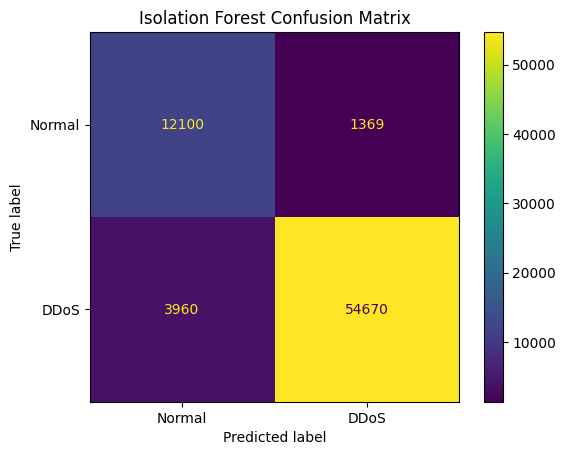

In [65]:
ConfusionMatrixDisplay.from_predictions(y_test,iso_preds,display_labels=['Normal','DDoS'])
plt.title("Isolation Forest Confusion Matrix")
plt.show()

Local Outlier Factor

In [66]:
from sklearn.neighbors import LocalOutlierFactor
lof=LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
print("Training Local Outlier Factor...")
lof.fit(X_train_scaled)

Training Local Outlier Factor...


LocalOutlierFactor(contamination=0.1, novelty=True)

In [67]:
lof_preds_raw=lof.predict(X_test_scaled)
lof_preds=[1 if x== -1 else 0 for x in lof_preds_raw]
print("/n--- Local Outlier Factor Results ---")
print(classification_report(y_test,lof_preds,target_names=['Normal','DDoS']))

/n--- Local Outlier Factor Results ---
              precision    recall  f1-score   support

      Normal       0.37      0.90      0.52     13469
        DDoS       0.97      0.64      0.77     58630

    accuracy                           0.69     72099
   macro avg       0.67      0.77      0.65     72099
weighted avg       0.85      0.69      0.73     72099



/tmp/ipython-input-1001162465.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=models, y=f1_scores, palette='viridis')


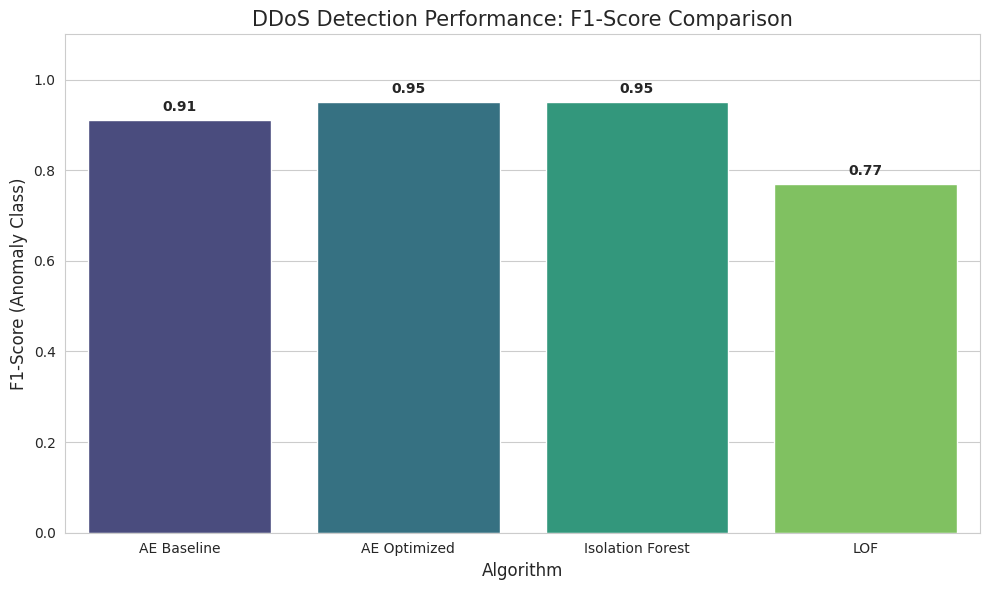

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

models = ['AE Baseline', 'AE Optimized', 'Isolation Forest', 'LOF']
f1_scores = [0.91, 0.95, 0.95, 0.77]  # Data from reports

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
barplot = sns.barplot(x=models, y=f1_scores, palette='viridis')

plt.title('DDoS Detection Performance: F1-Score Comparison', fontsize=15)
plt.ylabel('F1-Score (Anomaly Class)', fontsize=12)
plt.xlabel('Algorithm', fontsize=12)
plt.ylim(0, 1.1)

for i, score in enumerate(f1_scores):
    plt.text(i, score + 0.02, f'{score:.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

Overall performance of the Optimized Encoder and IsolationForest were great but Optimized Autoencoder would be preferred over IsolationForest for better precision and recall